In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
from pathlib import Path
EXP_DIR = Path('../../experiments/')
berea_mink = pd.read_csv('../../data/berea_64/minkowski64.csv')

In [9]:
from scipy.stats import norm

def plot_minkowski_distribution(exp_dir):
    seed_stats = pd.read_csv(exp_dir / 'seeds_analyze.csv')
    titles = ['$V$', '$B$', '$S$', '$\\xi$']
    for i, metric in enumerate(['V', 'S', 'B', 'Xi']):
        data = seed_stats[metric]
        fig = plt.figure(figsize=(10, 8))
        ax = fig.gca()
        sns.distplot(
            data,
            kde=False,
            hist_kws={'weights': np.ones_like(data) / len(data)},
            color='b',
            label='reconstruction',
            ax=ax
        )
        sns.distplot(
            berea_mink[metric],
            kde=False,
            hist_kws={'weights': np.ones_like(berea_mink[metric]) / len(berea_mink[metric])},
            color='r',
            label='training',
            ax=ax
        )
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        x = np.linspace(xmin, xmax, 100)
        kde = norm.pdf(x, data.mean(), data.std())
        k = ymax / kde.max()
        ax.plot(x, kde * k, color='b', linewidth=2, label='оценка $\\cal{N}$')
        
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        
        ax.set_xlabel(titles[i], fontsize=18) 
        ax.set_ylabel('$p$', fontsize=18) 
        ax.legend(fontsize=16)
        plt.title(f"Распределение функционала Минковского {titles[i]}", fontsize=20)
        plt.show()
        plt.close(fig)

In [7]:
from utils import two_point_correlation


def correlation_function(cov):
    p = cov[0]
    return (cov-p**2)/(p-p**2)


def plot_correlation_pph(exp_dir, dataset_dir):
    orig_files = list((dataset_dir / 'covariance_stats').glob('*.csv'))
    orig_pphs = []
    for file in orig_files:
        cov_pph = pd.read_csv(file)
        orig_pphs.append(cov_pph.values.T)
    orig_pphs = np.array(orig_pphs)
    
    orig_avg_pph = np.mean(orig_pphs.reshape(-1, orig_pphs.shape[-1]), axis=0)
    orig_std_pph = np.std(orig_pphs.reshape(-1, orig_pphs.shape[-1]), axis=0)
    
    orig_avg_corr = np.mean([correlation_function(cov) for cov in orig_pphs.reshape(-1, orig_pphs.shape[-1])], axis=0)
    orig_std_corr = np.std([correlation_function(cov) for cov in orig_pphs.reshape(-1, orig_pphs.shape[-1])], axis=0)

    seeds_pphs = []
    seed_files = list((exp_dir / 'covariance_stats').glob('*.csv'))
    for file in seed_files:
        cov_pph = pd.read_csv(file)
        seeds_pphs.append(cov_pph.values.T)
    seeds_pphs = np.array(seeds_pphs)
    
    radial_avg_pph = np.mean(seeds_pphs.reshape(-1, seeds_pphs.shape[-1]), axis=0)
    radial_std_pph = np.std(seeds_pphs.reshape(-1, seeds_pphs.shape[-1]), axis=0)
    
    radial_avg_corr = np.mean([correlation_function(cov) for cov in seeds_pphs.reshape(-1, seeds_pphs.shape[-1])], axis=0)
    radial_std_corr = np.std([correlation_function(cov) for cov in seeds_pphs.reshape(-1, seeds_pphs.shape[-1])], axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.errorbar(
        range(len(radial_avg_pph)),
        radial_avg_pph,
        yerr=radial_std_pph,
        c="black",
        elinewidth=2,
        fmt='-',
        label="reconstruction",
        linewidth=2
    )
    ax.errorbar(
        range(len(orig_avg_pph)),
        orig_avg_pph,
        yerr=orig_std_pph,
        linestyle="--",
        linewidth=1,
        c="red",
        label="training"
    )
    ax.axvline(64, color="blue", linestyle="-.", linewidth=3)
    ax.text(64+2., 0.15, r'Training image size',rotation=90, fontsize=18)
    ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    ax.set_xlabel(r"Lag distance [voxels]", fontsize=18) 
    ax.set_ylabel(r"$S_2(r)$", fontsize=18)   
    ax.set_xlim(-1, 100)
    ax.set_ylim(0.0, 0.225)
    ax.grid()  
    ax.legend(fontsize=16) 
    plt.title("Radial two-point probability function pore phase", fontsize=20)
    plt.show()
    plt.close(fig)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.errorbar(
        range(len(radial_avg_corr)),
        radial_avg_corr,
        yerr=radial_std_corr,
        c="black",
        elinewidth=2,
        fmt='-',
        label="reconstruction",
        linewidth=2
    )
    ax.errorbar(
        range(len(orig_avg_corr)),
        orig_avg_corr,
        yerr=orig_std_corr,
        linestyle="--",
        linewidth=1,
        c="red",
        label="training"
    )
    ax.axvline(64, color="blue", linestyle="-.", linewidth=3)
    ax.text(64+2., 0.15, r'Training image size',rotation=90, fontsize=18)
    ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    ax.set_xlabel(r"Lag distance [voxels]", fontsize=18) 
    ax.set_ylabel(r"Correlation function", fontsize=18)
    ax.set_xlim(-1, 100)
    ax.set_ylim(-0.2, 1.0)
    ax.grid()  
    ax.legend(fontsize=16)
    plt.title("Correlation function plot", fontsize=20)
    plt.show()
    plt.close(fig)

## Experiment 2019-02-25 12:13

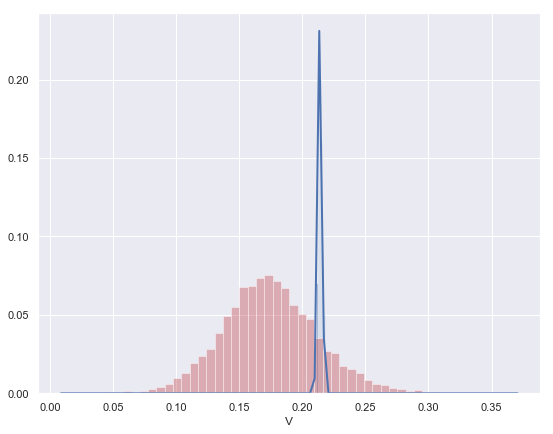

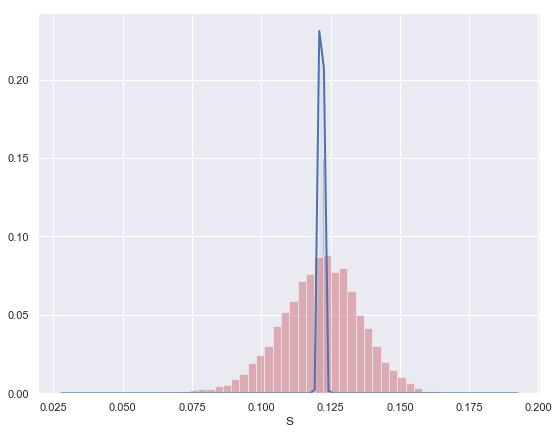

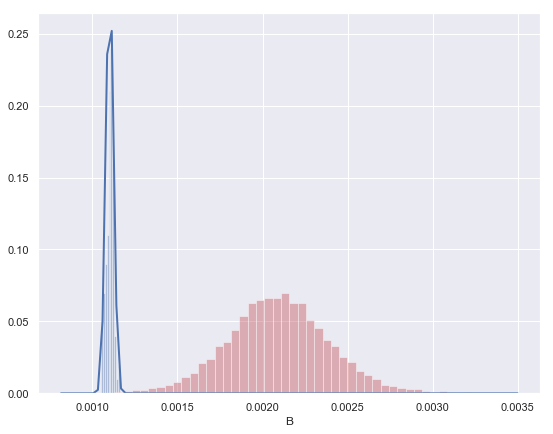

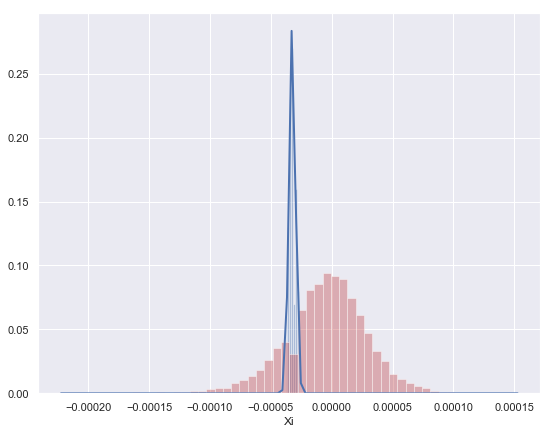

In [8]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-02-25_12_13'))

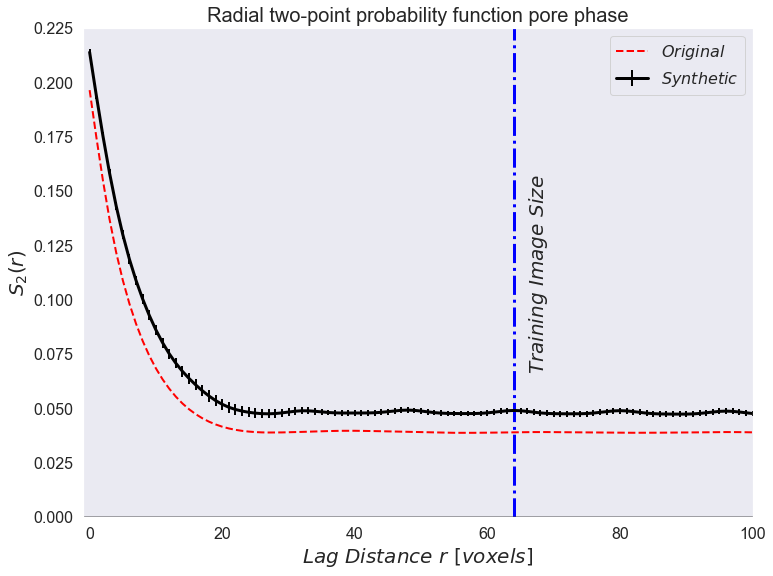

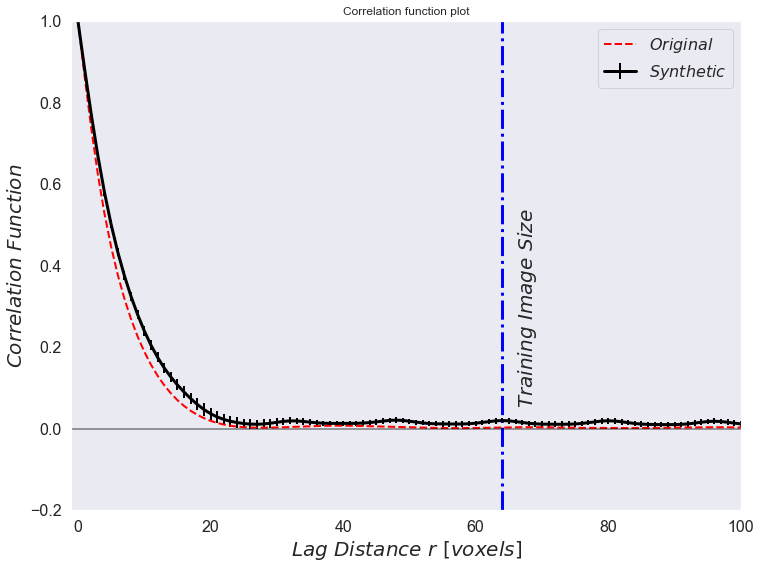

In [173]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-02-25_12_13'))

## Experiment 2019-03-21 16:30

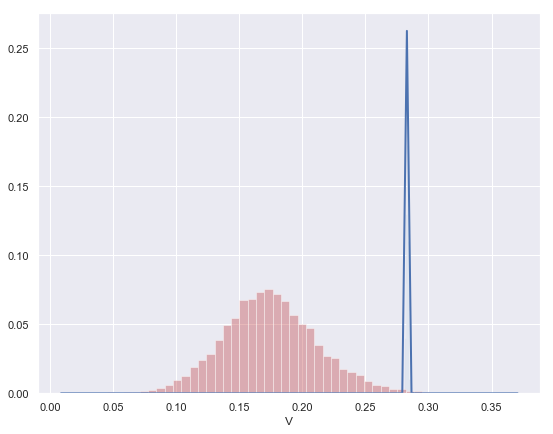

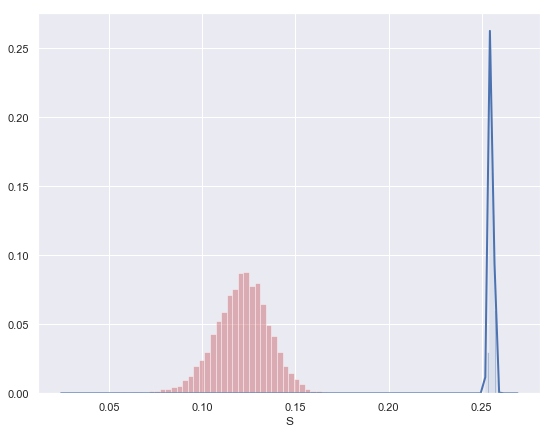

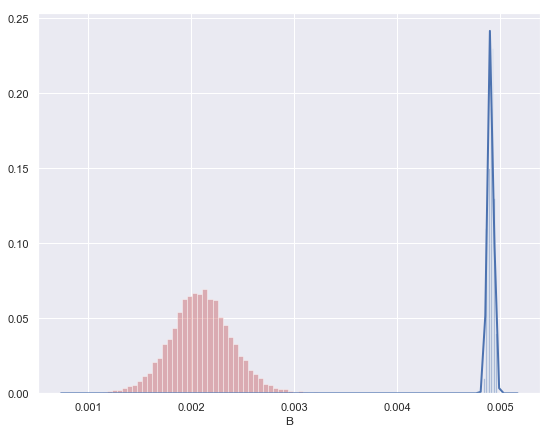

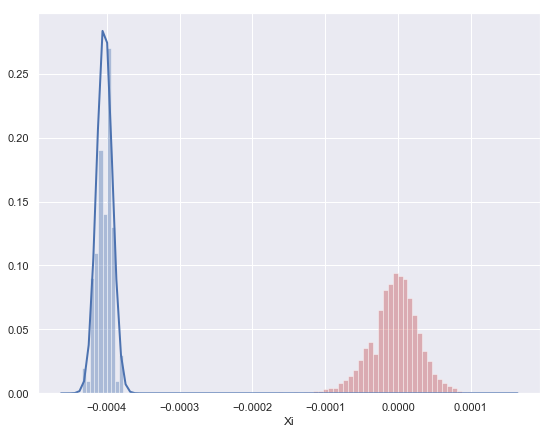

In [9]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-03-21_16_30'))

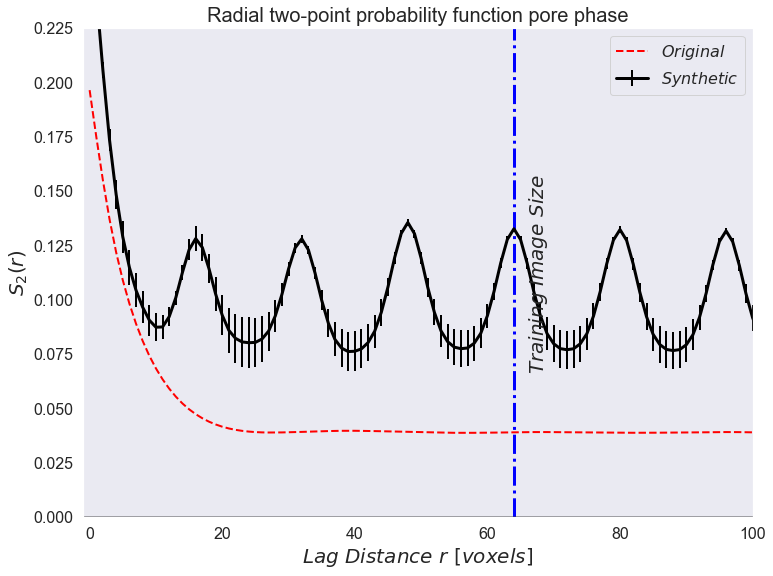

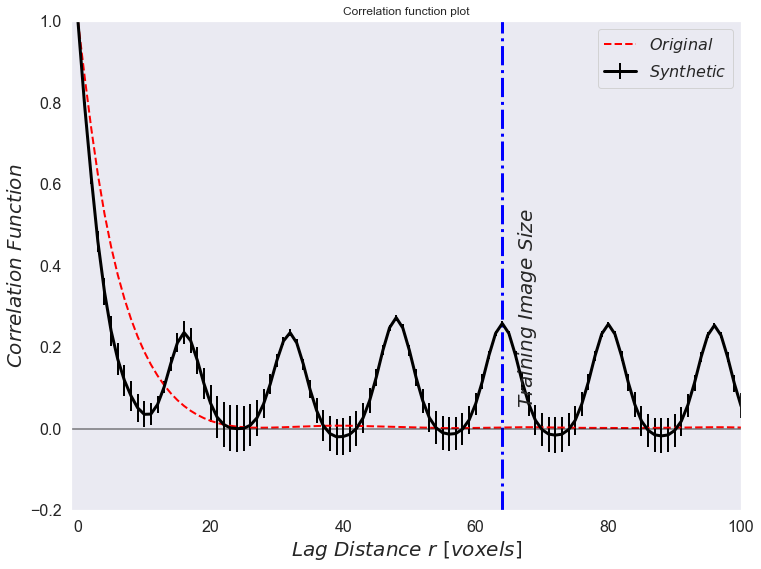

In [175]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-03-21_16_30'))

## Experiment 2019-03-27 14:43

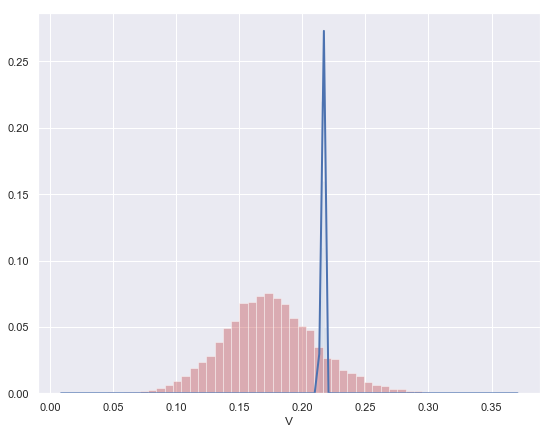

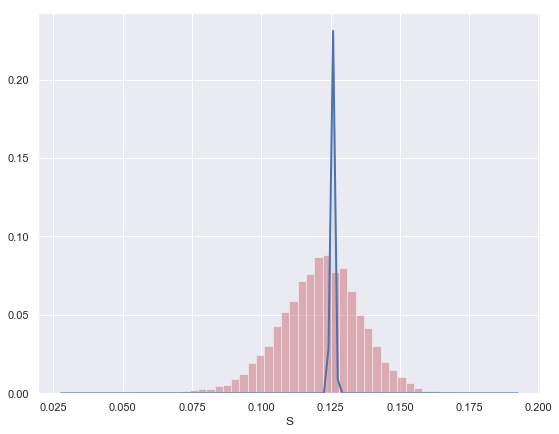

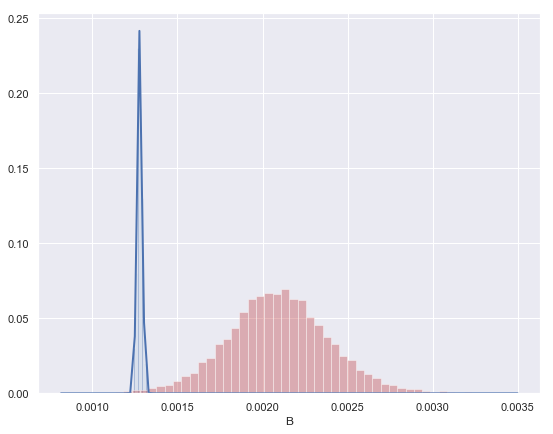

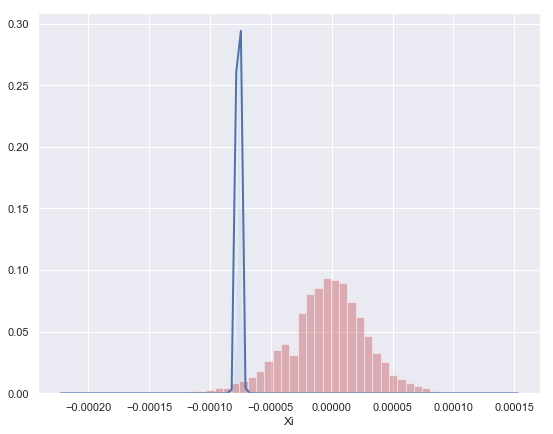

In [10]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-03-27_14_43'))

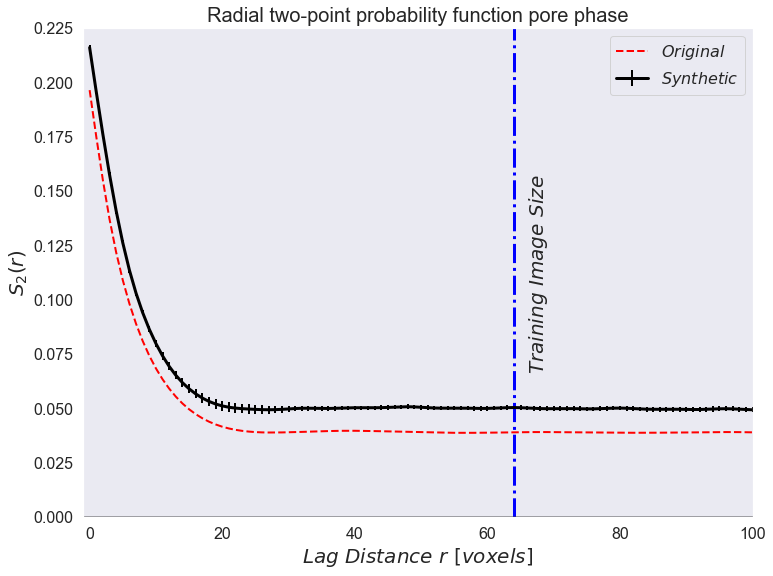

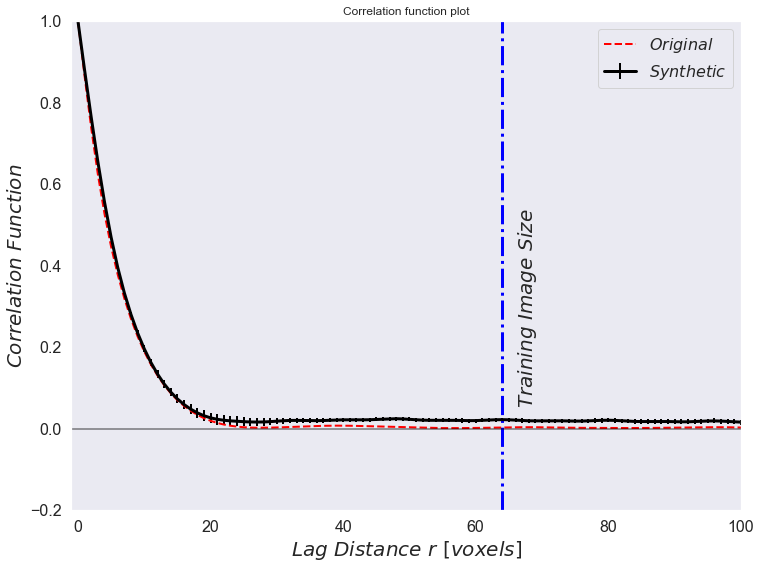

In [177]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-03-27_14_43'))

## Experiment 2019-04-13 19:32

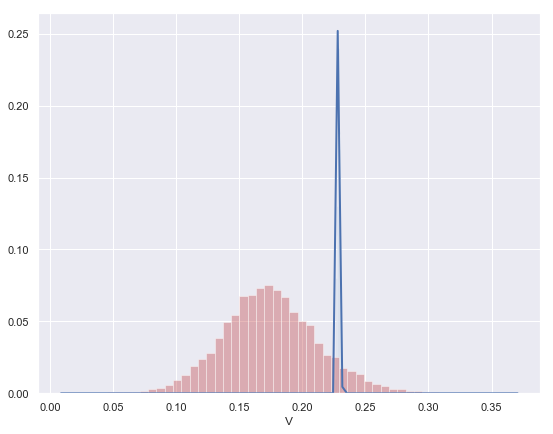

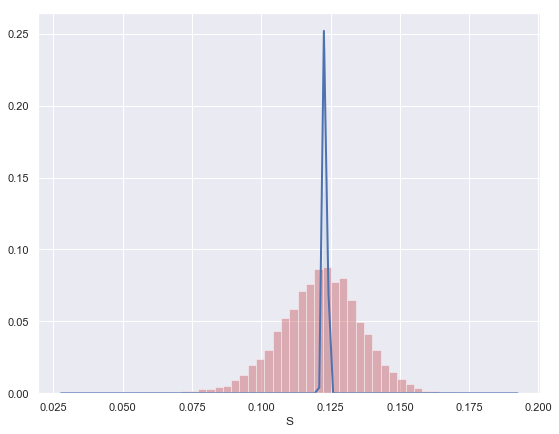

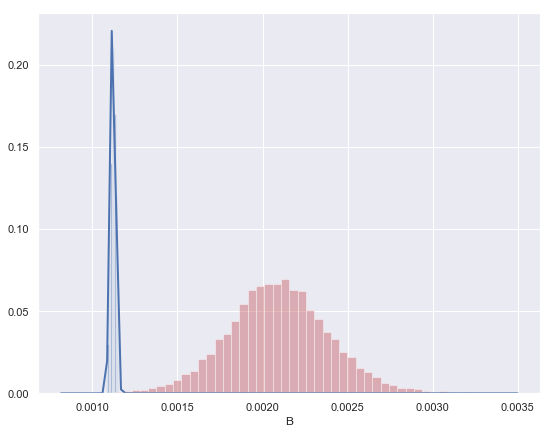

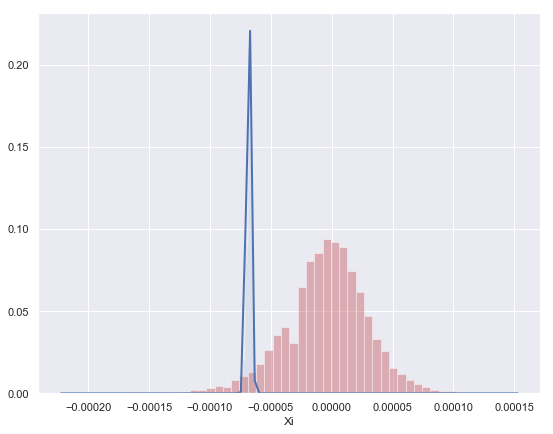

In [11]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-04-13_19_32'))

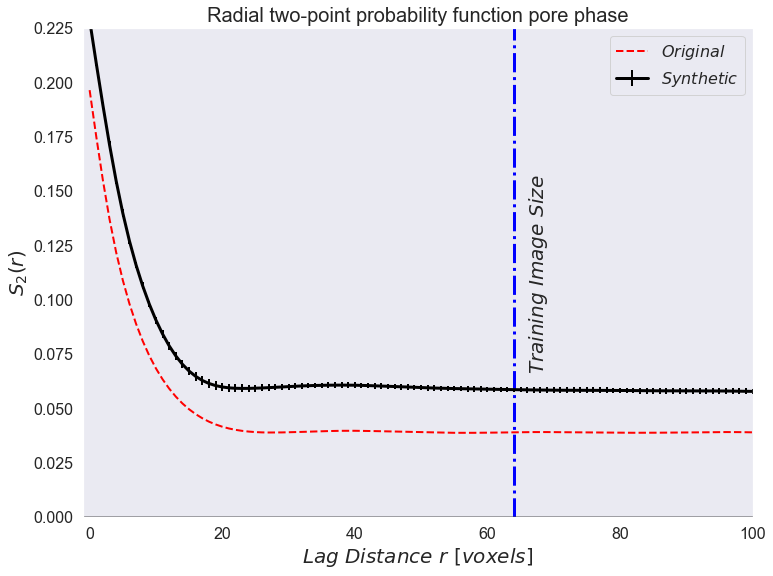

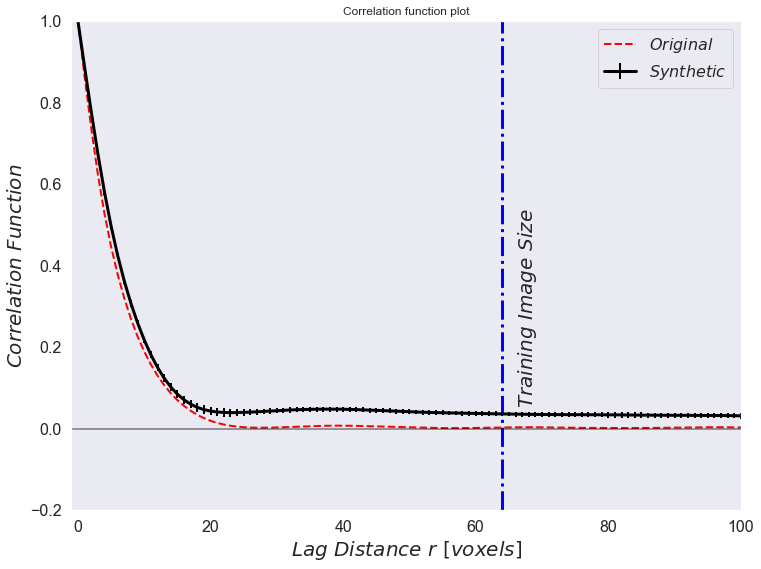

In [179]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-04-13_19_32'))

## Experiment 2019-04-16 11:30

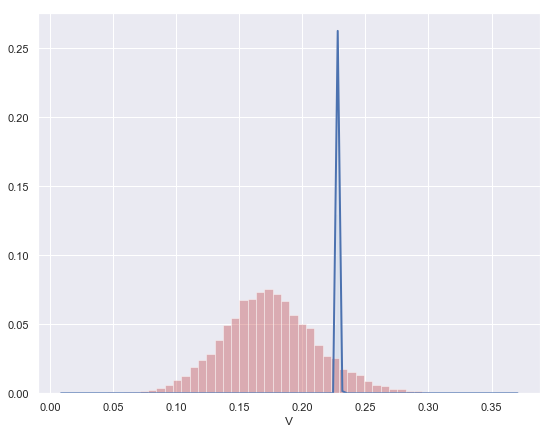

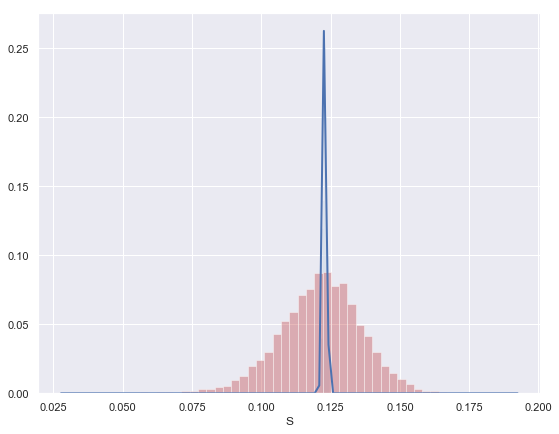

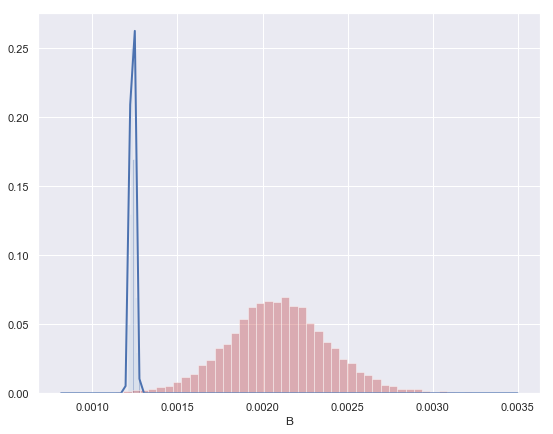

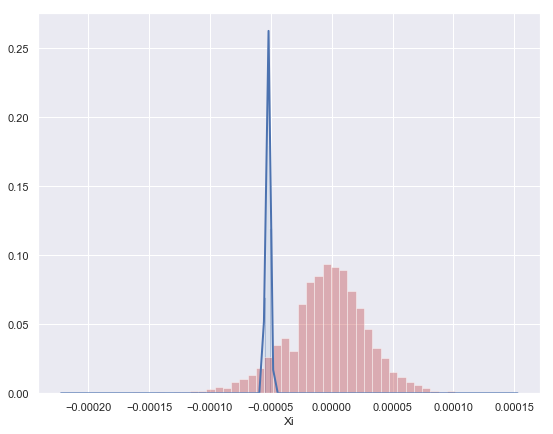

In [12]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-04-16_11_30'))

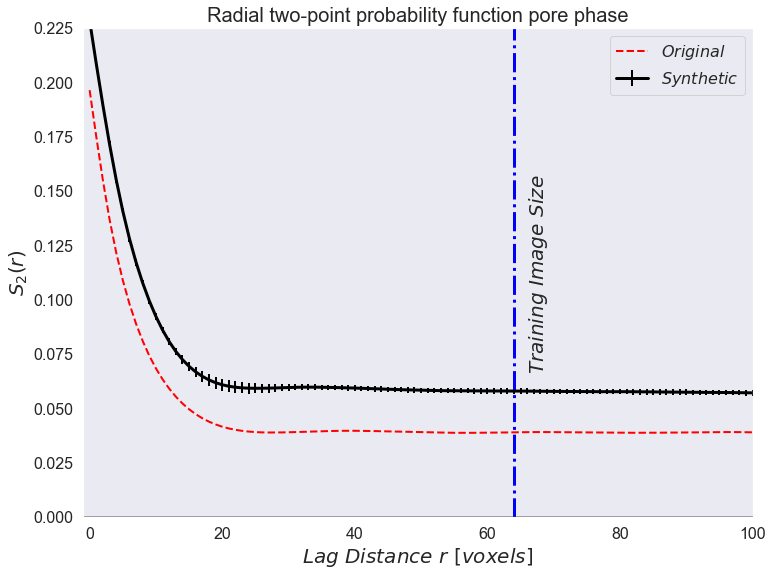

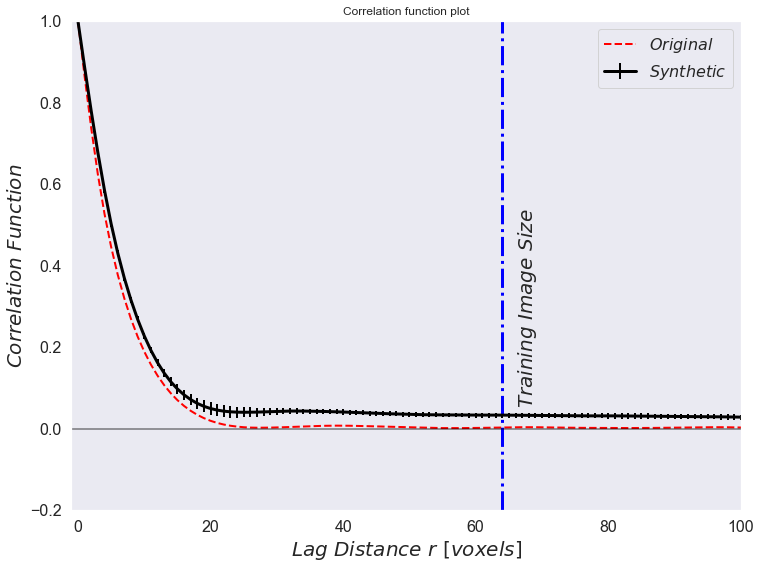

In [181]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-04-16_11_30'))

## Experiment 2019-04-18 12:07

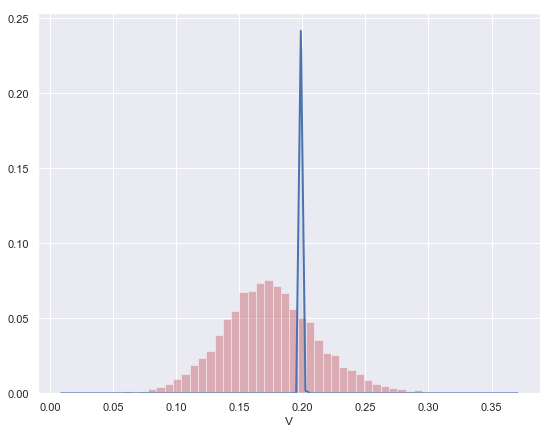

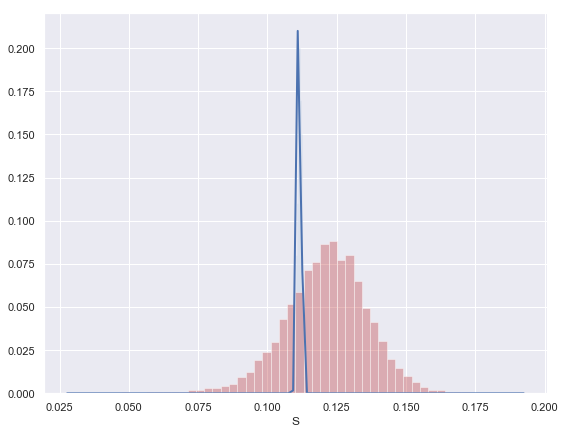

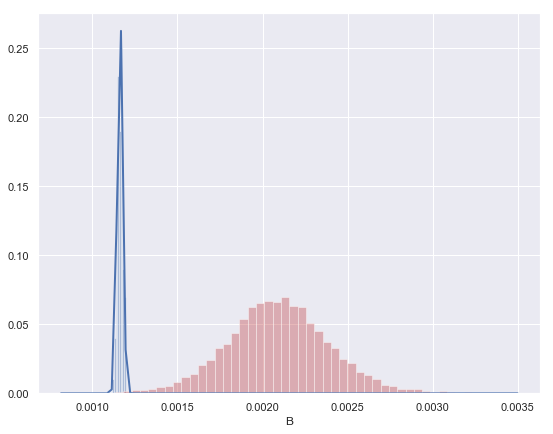

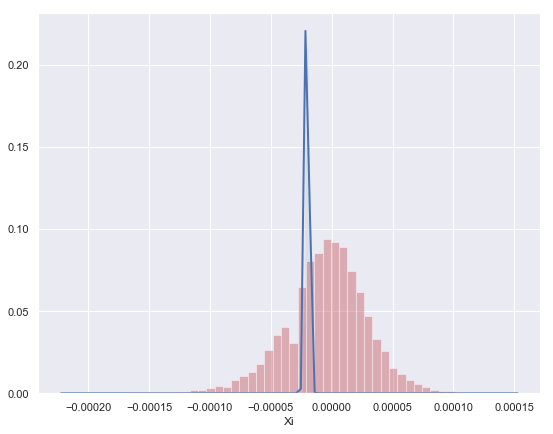

In [13]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-04-18_12_07'))

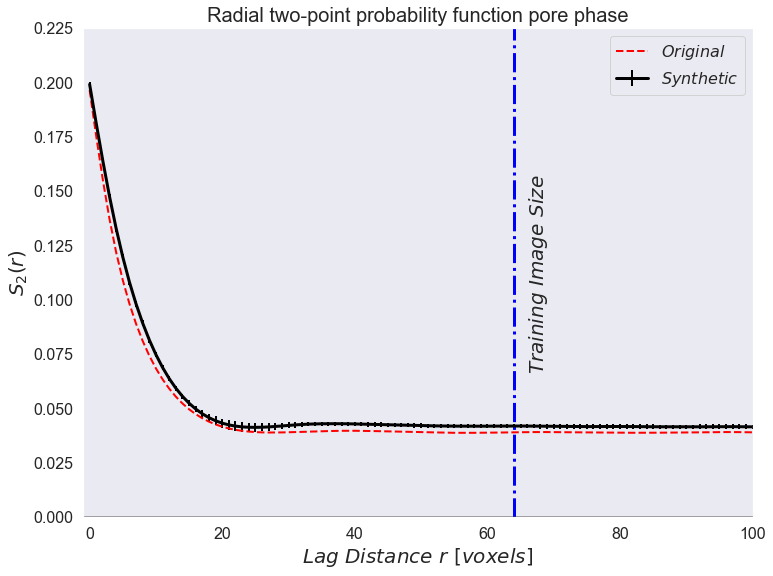

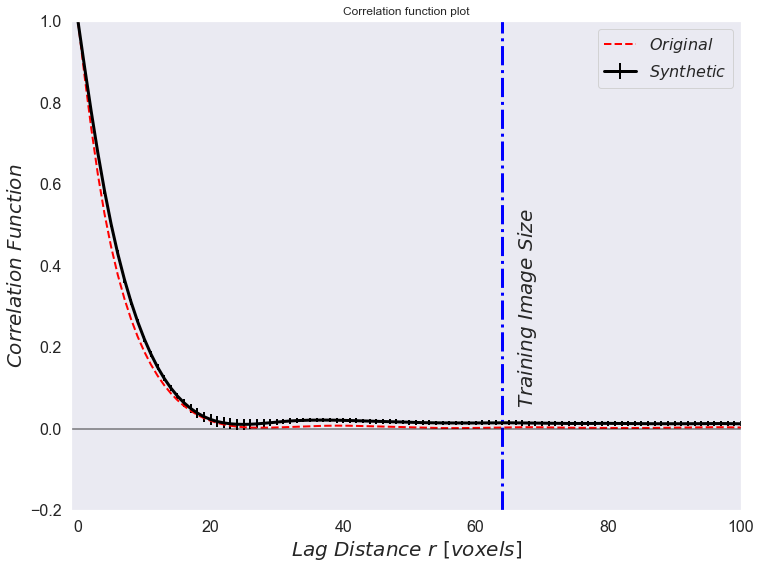

In [183]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-04-18_12_07'))

## Experiment 2019-04-29 14:19

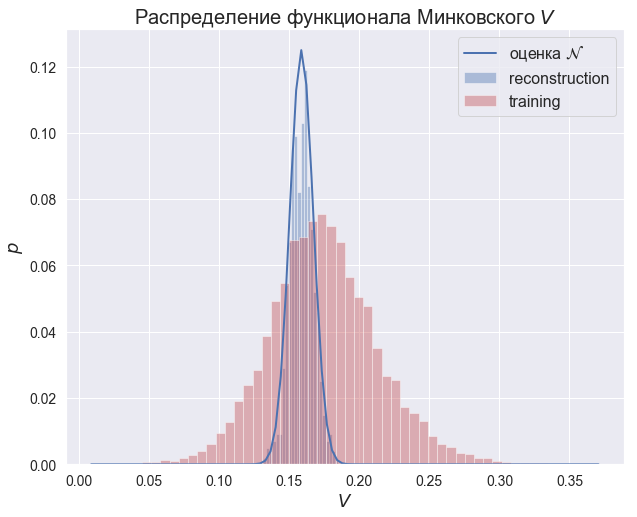

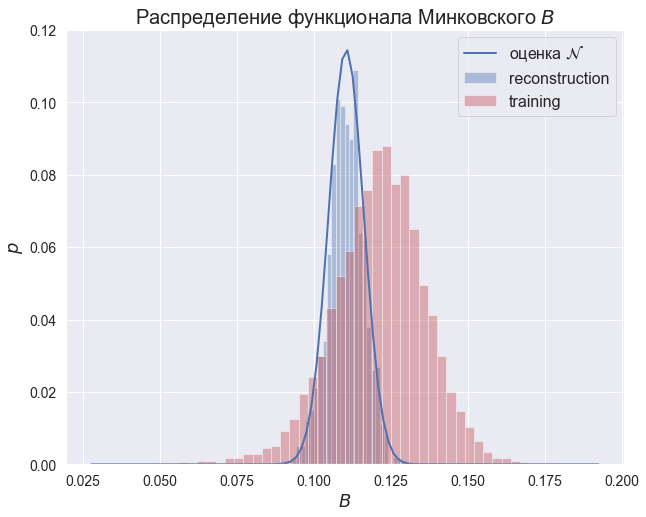

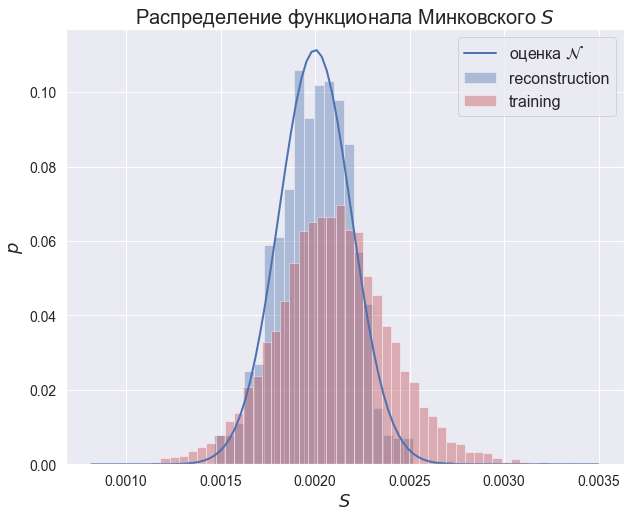

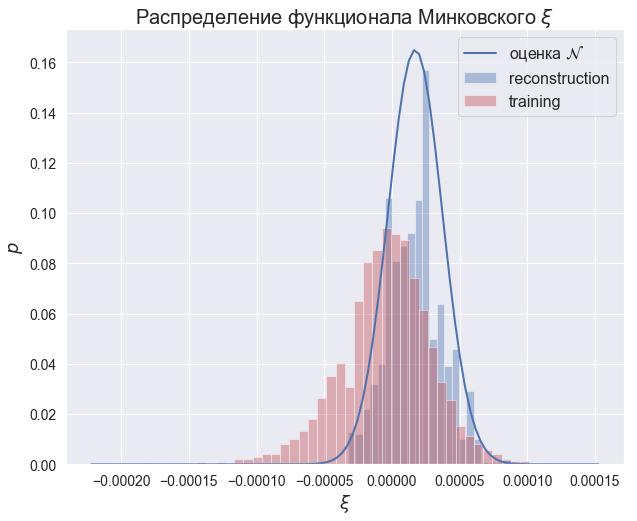

In [10]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / '2019-04-29_14_19'))

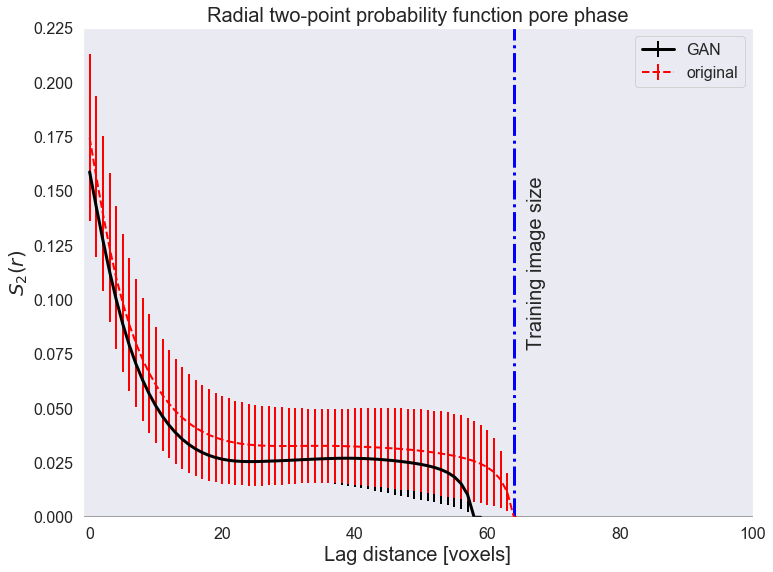

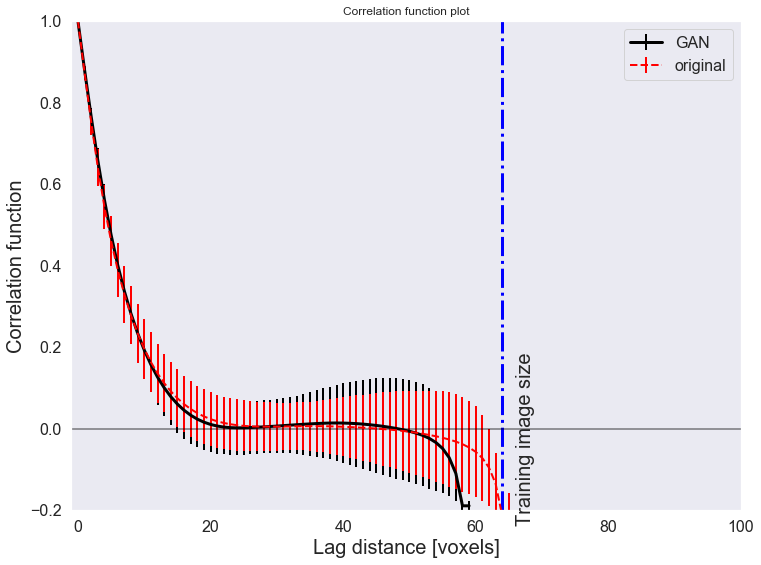

In [8]:
plot_correlation_pph(exp_dir=(EXP_DIR / '2019-04-29_14_19'), dataset_dir=Path('../../data/berea_64'))

## Original BEREA-pretrained

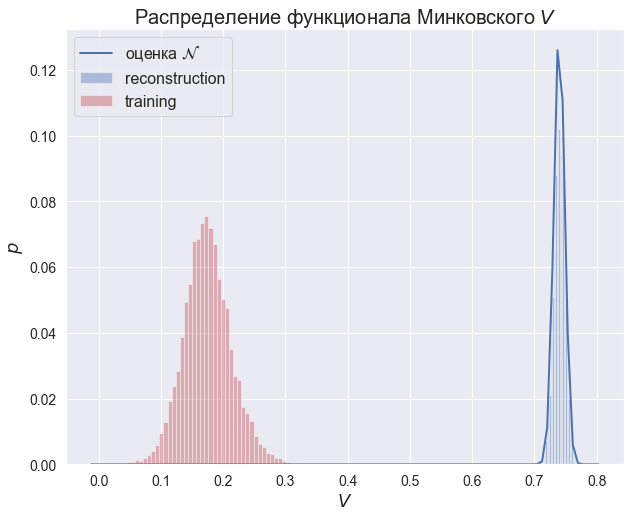

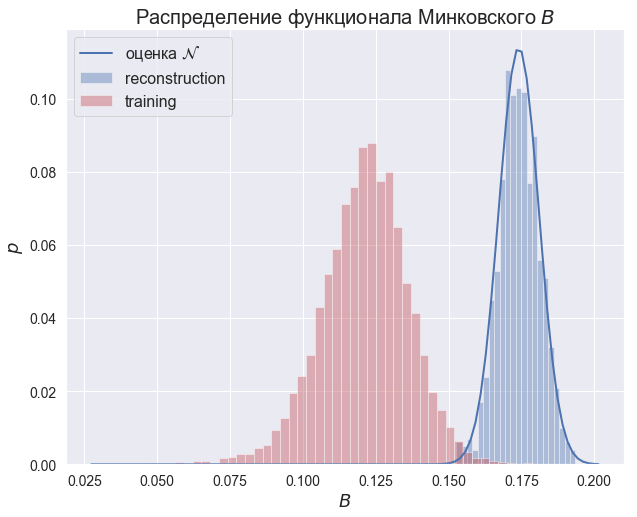

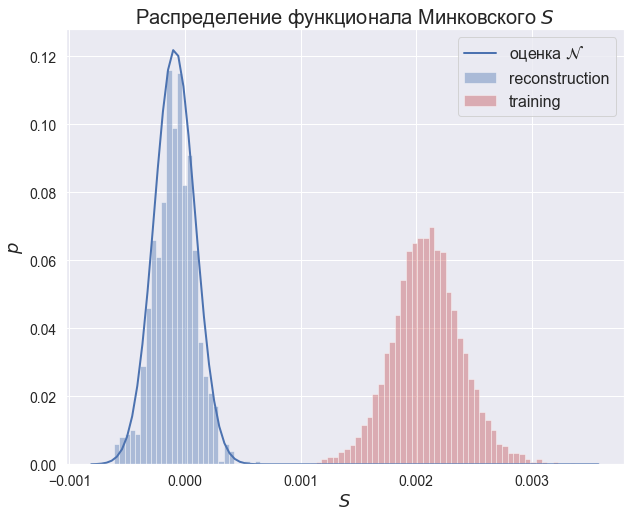

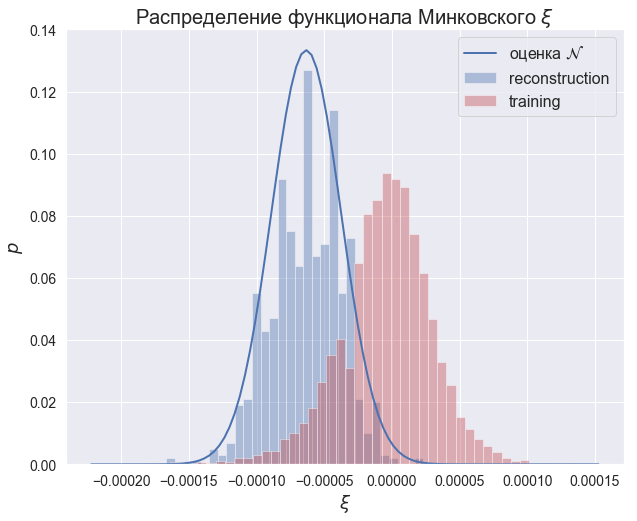

In [11]:
plot_minkowski_distribution(exp_dir=(EXP_DIR / 'original-berea'))

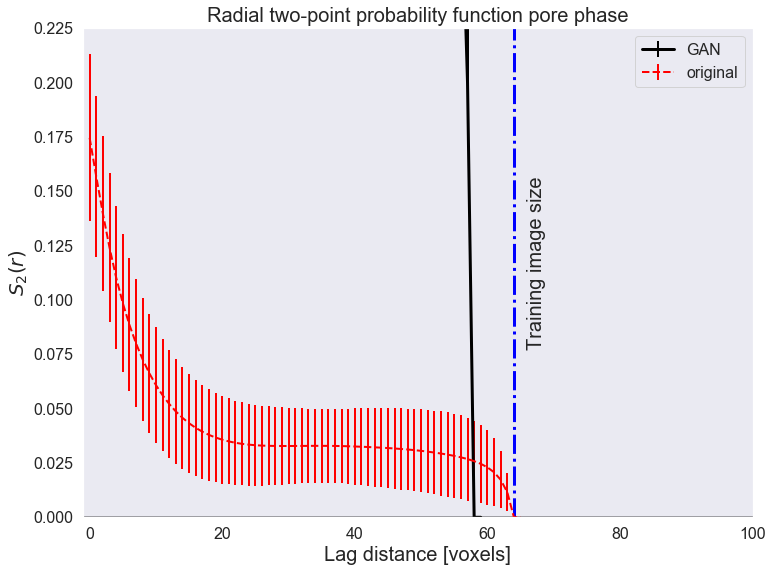

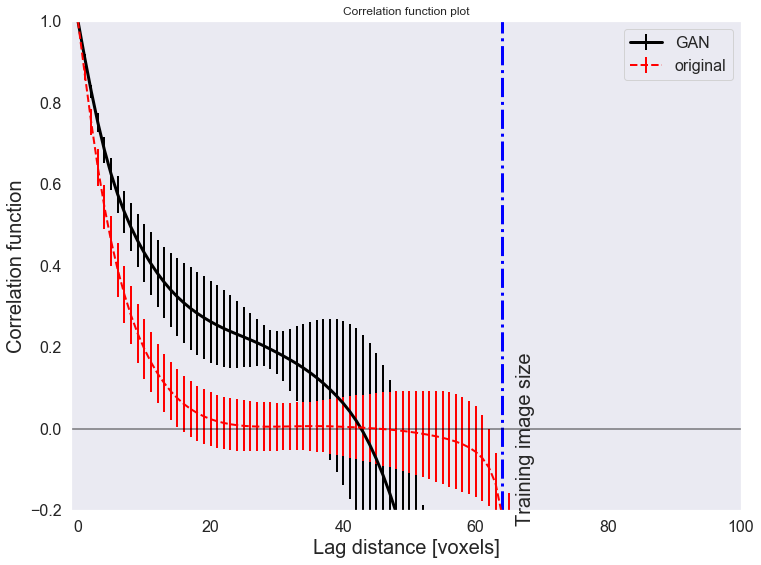

In [10]:
plot_correlation_pph(exp_dir=(EXP_DIR / 'original-berea'))